CS 4277: Deep Learning Group Project

## CS 4277: *Deep Learning* Group Project
### Members:
- Nicholas Hodge
- Joshua Peeples
- Jonathan Turner

### This project is our attempt at the Stanford RNA 3D Folding Challenge, found at:

https://www.kaggle.com/competitions/stanford-rna-3d-folding

**For this project to run:**

1. Install matplotlib in your Jupyter Kernel: Block [1]
2. Setup correct path files to your train dataset: Block [7] (there is a comment)

**Future work:**

1. Setup validation correctly
2. Test
3. Return Submission.csv as per requirements

In [13]:
# Uncomment and run if matplotlib not installed
# !  python -m pip install matplotlib

In [14]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm

# containers to accumulate metrics
batch_loss_history = [] # one entry per batch
epoch_loss_history = [] # one entry per epoch

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


# Training

In [16]:
NUC_TO_IDX = {
    "A": 0,
    "U": 1,
    "C": 2,
    "G": 3,
    "N": 4 # There are characters *other* than the above 4 sometimes. 'N' is standard for "unknown" (apparently)
}
PAD_IDX = 5
VOCAB_SIZE = len(NUC_TO_IDX) + 1

# Annotated to avoid later confusion - Nick
# This is inherits the Dataset class from pytorch to allow for the dataset to be an Iterable (i.e. work a LOT faster)
class RNADataset(Dataset):
    def __init__(self, seq_csv_path, coords_csv_path):
        # Read both train CSVs (the 'labels' csv -> 'coords')
        self.sequences_df = pd.read_csv(seq_csv_path)
        coords_df_raw = pd.read_csv(coords_csv_path)

        # We are going to get the base_id from each row in coords to associate them with the correct sequence.
        # 1SCL_A_5 becomes 1SCL_A
        coords_df_raw["base_id"] = coords_df_raw["ID"].apply(lambda x: "_".join(x.split("_")[:2]))

        # Now we are going to create groups of coords, where each group corresponds with the same sequence
        # Unfortunately some sequences have missing coord values, but I am going to assume that there are potential
        # sequences that have some missing and some not. So:

        # Method to remove entire groups where *any* row has missing coords
        def is_group_valid(group):
            return group[["x_1", "y_1", "z_1"]].notna().all().all() # returns only rows where all columns are good

        valid_groups = [
            group for _, group in coords_df_raw.groupby("base_id") if is_group_valid(group)
        ]

        # Concatenate all valid groups into a new coords_df
        self.coords_df = pd.concat(valid_groups, ignore_index=True)

        # Build groups and valid sequence IDs list
        self.coord_groups = self.coords_df.groupby("base_id")
        self.valid_ids = set(self.coord_groups.groups.keys())

        # Filter sequences to only include those with clean coordinate groups (prevents later tensors from being mishaped)
        self.sequences_df = self.sequences_df[self.sequences_df["target_id"].isin(self.valid_ids)]

    # Optional but Pytorch docs suggest this for 'Sampler' implmentations (might need that?)
    def __len__(self):
        return len(self.sequences_df)

    # Optional but Pytorch docs suggest this for speedup batched samples loading
    def __getitem__(self, idx):
        row = self.sequences_df.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        # Here we introduce standardization to the coordinates

        # TODO: calculate the following values somewhere in the document in case the dataset changes:
        # Currently precalculated values
        mean_x = 80.44731529117061
        std_x = 147.42231938515297
        mean_y = 84.04072703411182
        std_y = 114.92890150429712
        mean_z = 98.61122565112208
        std_z = 119.41066506340083

        coords_standardized = self.coord_groups.get_group(seq_id)[["x_1", "y_1", "z_1"]].values
        coords_standardized[:, 0] = (coords_standardized[:, 0] - mean_x) / std_x
        coords_standardized[:, 1] = (coords_standardized[:, 1] - mean_y) / std_y
        coords_standardized[:, 2] = (coords_standardized[:, 2] - mean_z) / std_z

        coords = torch.tensor(coords_standardized, dtype=torch.float32)

        return token_ids, coords

In [17]:
# Pad sequences in train_collate_fn
def collate_fn(batch):
    sequences, coords = zip(*batch)

    # Pad sequences with PAD_IDX
    seq_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)
    coord_padded = torch.nn.utils.rnn.pad_sequence(coords, batch_first=True, padding_value=0.0)

    # Mask should check against PAD_IDX
    mask = (seq_padded != PAD_IDX).unsqueeze(1).unsqueeze(2)

    return seq_padded, coord_padded, mask

In [18]:
# Source: Aladdin Persson on YouTube (then modified to have an encoder-only architecture)

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, query, mask):
        N, value_len, _ = values.shape
        _, key_len, _ = keys.shape
        _, query_len, _ = query.shape

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape: (N, heads, query_len, key_len)

        if mask is not None:
            # mask: (batch, 1, 1, seq_len) -> broadcastable to (batch, heads, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e9"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        attention = self.dropout(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # after einsum (N, query_len, heads, head_dim) then flatten last two dimensions

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)

        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class RNA3DFoldPredictor(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 max_length):
        super().__init__()
        self.embed_size = embed_size
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, heads, dropout, forward_expansion)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_size, 3)  # Predict (x, y, z)

    def forward(self, x, mask=None):
        N, seq_len = x.shape

        positions = torch.arange(0, seq_len).unsqueeze(0).expand(N, seq_len).to(x.device)

        out = self.token_embedding(x) + self.position_embedding(positions)
        for layer in self.layers:
            out = layer(out, mask)

        coords = self.fc_out(out)
        return coords

    def predict_multiple(self, x, n_samples=5):
        self.train()  # Activate dropout during inference
        with torch.no_grad():
            outputs = [self(x) for _ in range(n_samples)]
        return torch.stack(outputs)  # Shape: (n_samples, batch_size, seq_len, 3)

In [19]:
# live‑plotter
plot_display_handle = None   # will hold the DisplayHandle returned by display()

def plot_training_progress(epoch):
    # Draw the loss curves without clearing cell output
    global plot_display_handle

    # build figure
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(batch_loss_history, linewidth=1)
    axs[0].set_title("Batch loss")
    axs[0].set_xlabel("Batch #")
    axs[0].set_ylabel("Mean Squared Error")

    axs[1].plot(epoch_loss_history, marker="o")
    axs[1].set_title("Epoch loss")
    axs[1].set_xlabel("Epoch")

    plt.tight_layout()
    plt.suptitle(f"Training progress after epoch {epoch+1}", y=1.05, fontsize=14)

    # first call then create display, later calls then update it
    if plot_display_handle is None:
        plot_display_handle = display(fig, display_id=True)
    else:
        plot_display_handle.update(fig)

    plt.close(fig)  # prevent duplicate static image output

Max token ID: tensor(5, device='cuda:0')
Embedding size: 6
Output shape: torch.Size([4, 544, 3])


Epoch 1/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 1/10 | mean_loss: 1.1375 | last_batch_loss: 0.3330


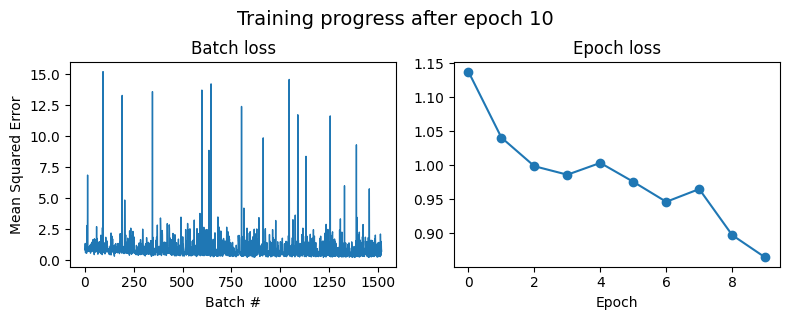

Epoch 2/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 2/10 | mean_loss: 1.0405 | last_batch_loss: 1.0806


Epoch 3/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 3/10 | mean_loss: 0.9983 | last_batch_loss: 0.4325


Epoch 4/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 4/10 | mean_loss: 0.9858 | last_batch_loss: 2.0132


Epoch 5/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 5/10 | mean_loss: 1.0032 | last_batch_loss: 0.3489


Epoch 6/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 6/10 | mean_loss: 0.9754 | last_batch_loss: 1.2659


Epoch 7/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 7/10 | mean_loss: 0.9459 | last_batch_loss: 0.3570


Epoch 8/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 8/10 | mean_loss: 0.9647 | last_batch_loss: 0.5402


Epoch 9/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 9/10 | mean_loss: 0.8970 | last_batch_loss: 1.2207


Epoch 10/10:   0%|          | 0/152 [00:00<?, ?batch/s]

Epoch 10/10 | mean_loss: 0.8641 | last_batch_loss: 0.7413


In [20]:
dataset = RNADataset("./data/train_sequences.csv", "./data/train_labels.csv") # replace with your *actual* path
loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Ran at batch_size=2 due to memory constraints FYI

model = RNA3DFoldPredictor(
    vocab_size=VOCAB_SIZE,
    embed_size=64,
    num_layers=4,
    heads=4,
    forward_expansion=4,
    dropout=0.2,
    max_length=4298, # nearest multiple of 2 is 8192...actual max is 4298
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

test_batch = next(iter(loader))
seqs, coords, mask = [x.to(device) for x in test_batch]

print("Max token ID:", torch.max(seqs))  # Should be <= 3
print("Embedding size:", model.token_embedding.num_embeddings)  # Should be 4

with torch.no_grad():
    outputs = model(seqs, mask)
print("Output shape:", outputs.shape)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_num = 0
    valid_batches = 0 # number of batches that actually updated the model
    last_batch_loss = None # loss of the most recent successful batch
    window_losses = [] # collects losses to compute 50 batch running mean

    # tqdm bar stays in the terminal after finishing (leave=True)
    batch_iterator = tqdm(
        loader,
        desc=f"Epoch {epoch+1}/{num_epochs}",
        unit="batch",
        leave=True,
        position=0,
    )

    for batch_num, (seqs, coords, mask) in enumerate(batch_iterator, start=1):
        # print("Max token ID in batch:", torch.max(seqs))
        seqs, coords, mask = seqs.to(device), coords.to(device), mask.to(device)

        # check for any NaN values
        if torch.isnan(coords).any() or torch.isinf(coords).any():
            batch_iterator.write(f"WARNING: NaN/Inf found in target coordinates in batch {batch_num}! Skipping batch.")
            continue

        optimizer.zero_grad()
        outputs = model(seqs, mask)

        # mask padding tokens only
        non_pad_mask = (seqs != PAD_IDX) # Shape: (batch_size, seq_len)
        outputs_masked = outputs[non_pad_mask]
        coords_masked = coords[non_pad_mask]

        # Calculate loss ONLY on non-padded elements
        if outputs_masked.nelement() == 0:
            batch_iterator.write(f"WARNING: Only padding elements in batch {batch_num}! Skipping batch.")
            continue

        loss = criterion(outputs_masked, coords_masked)

        # Skip if loss is NaN or Inf
        if torch.isnan(loss) or torch.isinf(loss):
            batch_iterator.write(f"WARNING: NaN detected in loss for batch {batch_num}! Skipping batch.")
            # Add more debugging here if needed: print outputs_masked, coords_masked
            continue # Skip optimization step for this batch

        # Backpropagation
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        last_batch_loss = loss.item()
        batch_loss_history.append(last_batch_loss)
        window_losses.append(last_batch_loss)

        total_loss += last_batch_loss
        valid_batches += 1

        # update tqdm bar postfix
        batch_iterator.set_postfix({"batch_loss": f"{last_batch_loss:.4f}"})

        # Every 50 valid batches, print the running mean and reset the window (disabled because it's spammy)
        if len(window_losses) == 50:
            mean50 = sum(window_losses) / 50
            # print(f"Mean loss over batches {batch_num-49}-{batch_num}: {mean50:.4f}")
            window_losses.clear()

    # Epoch‑level summary
    if valid_batches > 0:
        epoch_loss = total_loss / valid_batches
        epoch_loss_history.append(epoch_loss)
        print(
            f"Epoch {epoch+1}/{num_epochs}"
            f" | mean_loss: {epoch_loss:.4f}"
            f" | last_batch_loss: {last_batch_loss:.4f}"
        )
    else:
        print(f"Epoch {epoch+1} had no valid batches or zero total loss.")

    # live plot (comment out for end‑of‑training plot only)
    plot_training_progress(epoch)

In [21]:
model_path = './model.pth'
torch.save(model.state_dict(), model_path)

# Testing

In [22]:
IDX_TO_NUC = {v: k for k, v in NUC_TO_IDX.items()}
# Testing dataset
class RNATestDataset(Dataset):
    def __init__(self, test_seq_path):
        # Read test csv
        self.data = pd.read_csv(test_seq_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        return seq_id, token_ids

In [23]:
test_dataset = RNATestDataset(test_seq_path='./data/test_sequences.csv')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.load_state_dict(torch.load('model.pth')) # load trained model

model.to(device)
model.eval()

# enable dropout
for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

submission_rows = []

with torch.no_grad():
    for seq_id, token_ids in test_loader:
        seq_id = seq_id[0]  # unpack from list
        token_ids = token_ids.to(device).squeeze(0)  # [seq_len]
        sequence = [IDX_TO_NUC[i.item()] for i in token_ids]

        predictions = []

        # Generate 5 predictions
        for _ in range(5):
            output = model(token_ids.unsqueeze(0))  # [1, seq_len, 3]
            coords = output.squeeze(0).cpu().numpy()  # [seq_len, 3]
            predictions.append(coords)

        predictions = np.stack(predictions, axis=0)  # [5, seq_len, 3]

        seq_len = len(sequence)

        # Loop over each nucleotide in the sequence
        for i in range(seq_len):
            row = {
                "ID": f"{seq_id}_{i+1}",
                "resname": sequence[i],
                "resid": i+1
            }
            for j in range(5):  # 5 predictions
                row[f"x_{j+1}"] = predictions[j, i, 0]
                row[f"y_{j+1}"] = predictions[j, i, 1]
                row[f"z_{j+1}"] = predictions[j, i, 2]

            submission_rows.append(row)

# Convert to DataFrame and save
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

In [24]:
display(pd.read_csv('submission.csv'))

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,0.052247,0.206312,-0.376231,-0.445606,-0.718383,-0.196195,0.071519,-0.352742,-0.093607,-0.100609,-0.419570,-0.284850,-0.802650,-0.058874,-0.291665
1,R1107_2,G,2,-0.701086,0.060516,-0.252092,-0.510957,-0.482339,-0.120633,0.165478,-0.812212,-0.966943,-0.159577,-0.608722,0.127269,-0.511254,-0.685634,-0.498267
2,R1107_3,G,3,-0.126582,-0.940102,-0.475051,-0.308186,0.011996,-0.899217,0.116622,-0.642920,-0.359122,-0.263604,-0.435481,-0.247950,0.214497,-0.141016,-0.028632
3,R1107_4,G,4,-0.123474,-0.194733,-0.286495,-0.064280,-0.283967,0.100589,0.123299,-0.857656,-0.394849,0.309525,0.053764,0.222555,-0.407483,-0.528343,-0.166099
4,R1107_5,G,5,-1.217606,-0.090606,-0.090263,-0.861949,-0.300077,-0.038998,0.709765,0.153383,-0.633653,0.089729,-0.138228,-0.917040,-0.440791,0.416537,-0.014744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,R1190_114,U,114,0.126809,-0.181948,-0.209092,0.469276,0.075024,-0.994325,0.198268,-0.375760,-0.236403,-0.314860,-0.299142,-0.230495,0.084356,-0.866756,-0.649625
2511,R1190_115,U,115,-0.371321,1.048955,0.150344,-0.096249,0.075931,-0.291944,0.181242,0.071139,-0.388363,-0.306943,-0.153255,0.001224,-0.041424,-0.410281,-0.702275
2512,R1190_116,U,116,-0.908854,-0.575485,-0.302400,-0.963248,-0.120749,0.044450,-0.639442,-0.458145,-0.783379,-0.164908,-0.064504,-0.021986,0.232864,-0.119039,-0.194346
2513,R1190_117,U,117,-0.570374,0.110161,0.005762,-0.552604,-0.059749,0.157993,-0.466334,-0.527493,0.086256,0.569128,-0.388683,0.010540,-0.350516,-0.457235,-0.412734
